# Summary of Findings

### Introduction

From a marketing perspective, it's clear that the goal of any advertiser is to increase the amount of people who views the advertisement, so that they can have more people view the message (most commonly promoting a product of some sort). In this case, one of the main focuses of the advertising groups is to predict the `Impressions` of an ad based on other factors so they can minimize costs while generating more Impressions. This means our model will need to be a **regression model** in order to predict a specific number rather than a binary-type prediction.

The goal for our model is to achieve the highest r2-score (calculated using sci-kit learn). This means achieving the most accurate predictions possible. Wikipedia describes this score as *the proportion of the variance in the dependent variable that is predictable from the independent variable*, making it a nice indicator of how useful the model predictions are. The r2-score is a better indicator in comparison to other objectives such as minimizing RMSE because it is really sensitive to outliers. From my previous investigation into this dataset, I discovered a very large skew that resulted in most of the dataset being outliers, thus it would make more sense to utilize an r2-score objective.

Let's jump right in.

### EDA

My problem differed from my original question in proj03, so I decided that some additional EDA here would be helpful in determining features for the model.

I began by using seaborn to create plots between `Spend` and `Impressions`, noting differences in `CountryCode` using the hue argument in the sns.scatterplot function.

The first plot tells me that there is some correlation between `Spend` and `Impressions`, which is to be expected because paying more money will likely increase the area the ad is displayed in. This would typically result in the ad reaching more people.

However, the plot fails to give a good idea of the differences in `CountryCode` because of the huge cluster of datapoints. I decided to play around with the axes sizes and find a window that gives a better idea of correlation based on country.

After trying different axes sizes, it's still slightly hard to differentiate, but we can see that the united states and united kingdom have a relatively widespread range, primarily in the middle to bottom section of the plot. What looks to be iraq, switzerland, and denmark are mostly in the upper half of the plot. Through this, we determine that `CountryCode` has a moderate correlation with the values of `Impressions` which we can account for in our advanced model using something similar to StdScalerByGroup.

Another factor to `Impressions` that could be interesting when visualized is the StartDate. I made another plot to determine how `Impressions` changes over time and if there are any patterns.

From this plot, we can see that StartDate has a significant peak in `Impressions` in October 2019. I did some research out of curiosity, and I found that many international elections happened in November 2019, which would explain the spike in political advertisements leading up to that time (Source: https://en.wikipedia.org/wiki/2019_national_electoral_calendar). Unfortunately, the span of 2018-2019 fails to expose any predictable patterns.

**In addition, I researched some methods to encode the datetime format of StartDate and discovered multiple ways including either "explode the date into a set of categorical features encoded in boolean form using the 1-of-K encoding" as stated by ogrisel on stackoverflow.com or to convert the datetime to an ordinal feature.**

We also know that EndDate doesn't really have any effect, especially since there are null EndDate values. However, when paired together, there might be a noteworthy relationship concerning the duration that the ad was played. 

Now, we can get started making a baseline model Pipeline.

### Baseline Model

The features I decided on for the baseline model are `CountryCode, OrganizationName, AgeBracket, Spend, Segments, Interests, BillingAddress, Currency Code`. These factors are most likely to play a role in the number of views an ad gets. The 7 nominal features are `CountryCode, OrganizationName, AgeBracket, Segments, Interests, BillingAddress, and CurrencyCode` and the 1 quantitative feature is `Spend`. 

One feature I wanted to use was the `BillingAddress` with a geographic transformer that would assign it a weight based on its distance from the most populated state in the country based on the `CountryCode`, but then I realized that the Billing Address of the company wouldn't have any influence on where the ad itself is played.

I also considered using LabelEncoder for the categorical data, but the different categories were not ordinal data, and there were many different unique values in each category. This made it a poor choice, because it would assign an ordering to the non-ordered data, causing more weight to be placed where it shouldn't be.

Although the r2-score of 0.252699 is rather low, it's not completely horrible for a baseline model. I think the baseline features aren't very meaningful without deriving more featuers out of them, so it's not surprising that the r2-score is so low. The low r2-score, however, indicates the possibility that some input factors in the baseline model had correlations too weak to reasonably predict the `Impressions`. It's also still better than a negative r2-score which would indicate opposite predictions.

### Final Model

The first additional feature I added is the StartDate converted to an ordinal variable as `StartDate_ordinal`. I decided on this feature because I noticed some spikes in `Impressions` when plotted against StartDate. Although i couldn't distinguish a pattern, I felt like there was a possibility it could be helpful for the regressor model to predict `Impressions`. I also had the option to explode the datetime feature into separate features depending on year, month, and day, but I decided against this because there are 2 years worth of data, thus reducing the value of isolating month and day. To create this feature, I imported datetime from the datetime package and used the toordinal function. I then subtracted the minimum value from each value in the column to have the number of days begin from the time the first ad was played in 2018.

The second additional feature I added is the number of Ages targeted or `AgesIncluded`. I figured that if an advertiser focused their ad for a specific age group, then the ad would reach less people. Inversely, if the advertiser didn't specify a target age range, then it would reach more people. To create this feature, I did some research on Snapchat usage across demographics at the end of 2019. I came across this infograph that indicated 97% of SnapChat users were 64 years old or younger (Source: https://media.sproutsocial.com/uploads/2020/01/snapchat-demos-2020.png). This led me to subtract 64 by each lower boundary because that would be the number of ages that would typically view that ad. For ads that didn't specify an age range, I simply filled them with 64 since they essentially target all 64 years of age.

The next feature I decided to add was the `Duration` the ad was made available. I decided on this feature because an ad has greater chance to reach more people when broadcasted for a longer period of time. Especially with people travelling to various places at various times, a higher duration has potential to be viewed by many more people. I did this by simply subtracting the `EndDate` by the `StartDate`.

I also ended up Standard Scaling the `Duration` and `AgesIncluded` by `CountryCode` because I still felt there may have been a difference in `Impressions` across different countries.

My next step was to test potential regressors such as the Ridge Regressor or Lasso Regressor. 

I started with the classic Linear Regression as a kind of control group. The r2-score for Linear Regression was 0.458340. This is already a significant increase from the baseline model, which indicates that the additional features had a greater correlation with `Impressions` than the base features.

I proceeded to test the Ridge Regressor for the final model because it accounts for the coefficient sizes. The alpha argument also allows flexibility on the fitting of the data. I decided to play around with the alpha values to determine the best alpha value, but I also concluded that low alpha values will almost always produce high r2-scores at the drawback of overfitting. To do this, I utilized the np.arange function to create an array of [0.0, 0.1, ..., 1.0] and tested Ridge for each one. The alpha value of 0.1 ended up producing the greatest r2-score of 0.4600069.

Next, I was curious to try using the Lasso Regressor because it's functionality is unique in that it tends to "prefer solutions with fewer non-zero coefficients, effectively reducing the number of features upon which the given solution is dependent," which sounds good for this dataset where such correlations aren't immediately obvious, but it also risks missing important relationships in the data (Source: sklearn documentation). The best r2-score for this Regressor was 0.457440 with alpha=1.0.

After testing these regressors, it can be concluded that the Ridge Regressor had the most accurate predictions. The improved r2-score of 0.4600069 had a significant improvement with a difference of +0.2073079. Now, let's adjust our Final Model to test how accurate predictions on `Spend` are.

After testing the model's predictions of `Spend`, we get an r2-score of 0.798638 which is a massive improvement over its predictions of `Impressions`. We can conclude that the model features (e.g. `CountryCode`, `AgesIncluded`, etc.) have a higher correlation with `Spend` than `Impressions`.

### Evaluation of Fairness

Conducting a permutation test by `CountryCode` resulted in a p_val of 0.81. Because the p_val of 0.81 was greater than the significance level of 0.05, we can conclude that there isn't a statistically significant difference in Snapchat `Impressions` between countries. I conducted the permutation test using the r2_score metric.

# EDA

In [1]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

# Stop warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
# Read csv files into DataFrames and concatenate them together.
ads_2018 = pd.read_csv('PoliticalAds_2018.csv')
ads_2019 = pd.read_csv('PoliticalAds_2019.csv')
combined_df = pd.concat([ads_2018, ads_2019])

# Convert StartDate and EndDate columns into datetime format.
# Note: the +00:00 represents the timezone
combined_df['StartDate'] = pd.to_datetime(combined_df['StartDate'])
combined_df['EndDate'] = pd.to_datetime(combined_df['EndDate'])
combined_df.head()

,ADID,CreativeUrl,Currency Code,Spend,Impressions,StartDate,EndDate,OrganizationName,BillingAddress,CandidateBallotInformation,...,Location Categories (Included),Location Categories (Excluded),Interests,OsType,Segments,Language,AdvancedDemographics,Targeting Connection Type,Targeting Carrier (ISP),CreativeProperties
0,3543bda6548f0e2c5ebfbac43c7443cc2383e90e2761ca...,https://www.snap.com/political-ads/asset/4eb5f...,USD,623,55373,2018-10-18 16:57:38+00:00,2018-11-06 23:00:00+00:00,Bully Pulpit Interactive,"1445 New York Ave NW,Washington,20005,US",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8ee4c45b5b6fcf1fb40a169177e79ebd2b39c8a3930703...,https://www.snap.com/political-ads/asset/91b82...,GBP,118,48450,2018-10-05 15:50:13+00:00,2018-10-14 23:30:00+00:00,The Labour Party,"Kings Manor,Newcastle,NE16PA,GB",NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,en,NaN,NaN,NaN,web_view_url:https://labour.org.uk/register-to...
2,0e7e1d4cca496a43a93143342f7749fea8c415e45a5146...,https://www.snap.com/political-ads/asset/560f0...,USD,45,13965,2018-09-25 20:57:04+00:00,2018-09-30 03:59:59+00:00,ACRONYM,US,NaN,...,NaN,NaN,"Collegiates,Green Living Enthusiasts,Outdoor &...",NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,web_view_url:https://join.knockthe.vote
3,ad346ac624a818fdee801416f09a18442a0b80d5e6ea17...,https://www.snap.com/political-ads/asset/11917...,USD,971,91817,2018-10-18 17:48:51+00:00,2018-11-06 23:00:00+00:00,Bully Pulpit Interactive,"1445 New York Ave NW,Washington,20005,US",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,a8a3a66880fd17c6c3863f1f38373d95ec2551f204eed1...,https://www.snap.com/political-ads/asset/eb9d0...,USD,102,31835,2018-10-09 00:17:27+00:00,NaT,OpenPoll Inc,US,NaN,...,NaN,NaN,NaN,NaN,Provided by Advertiser,NaN,NaN,NaN,NaN,web_view_url:https://poll.openpoll.io/b856fce8...


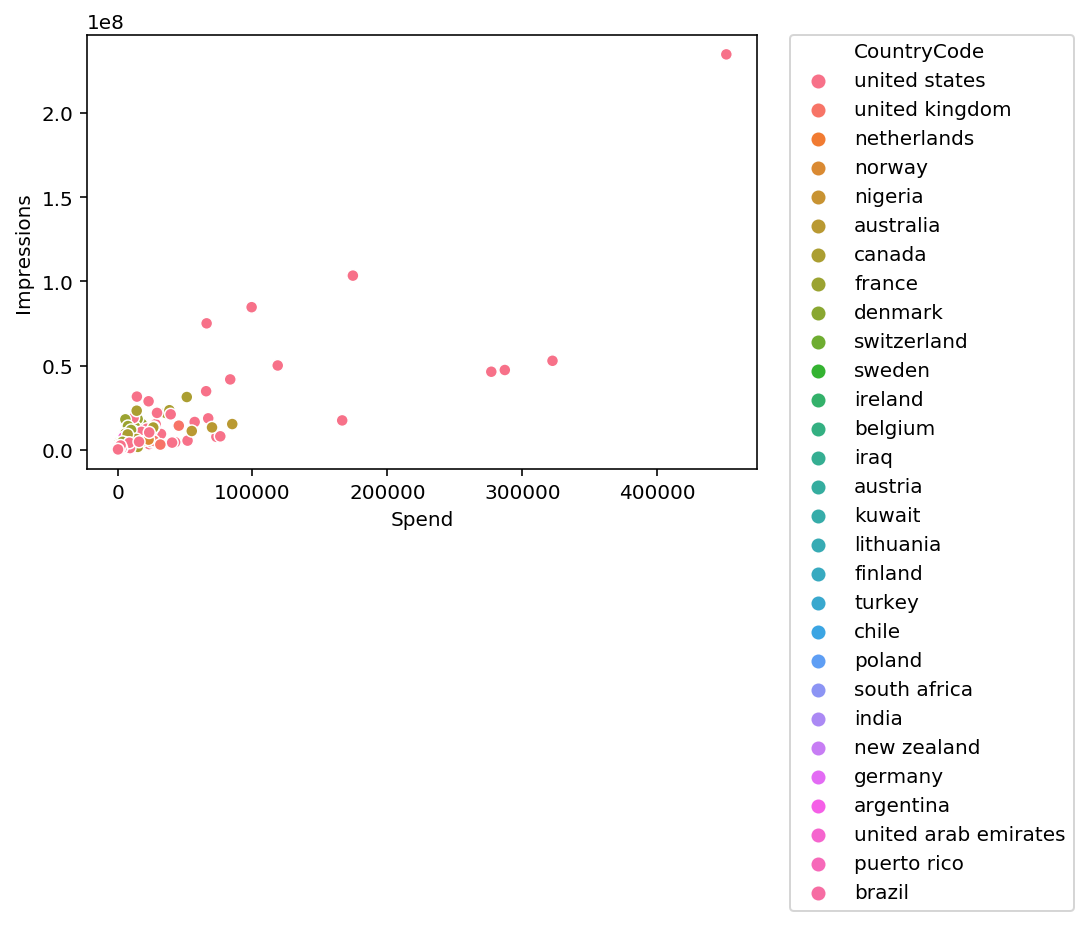

In [3]:
# Let's first see if there are any observable relationships in the data using plots.
ax = sns.scatterplot(x='Spend', y="Impressions", data=combined_df, hue='CountryCode')

# Move legend outside the plot figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

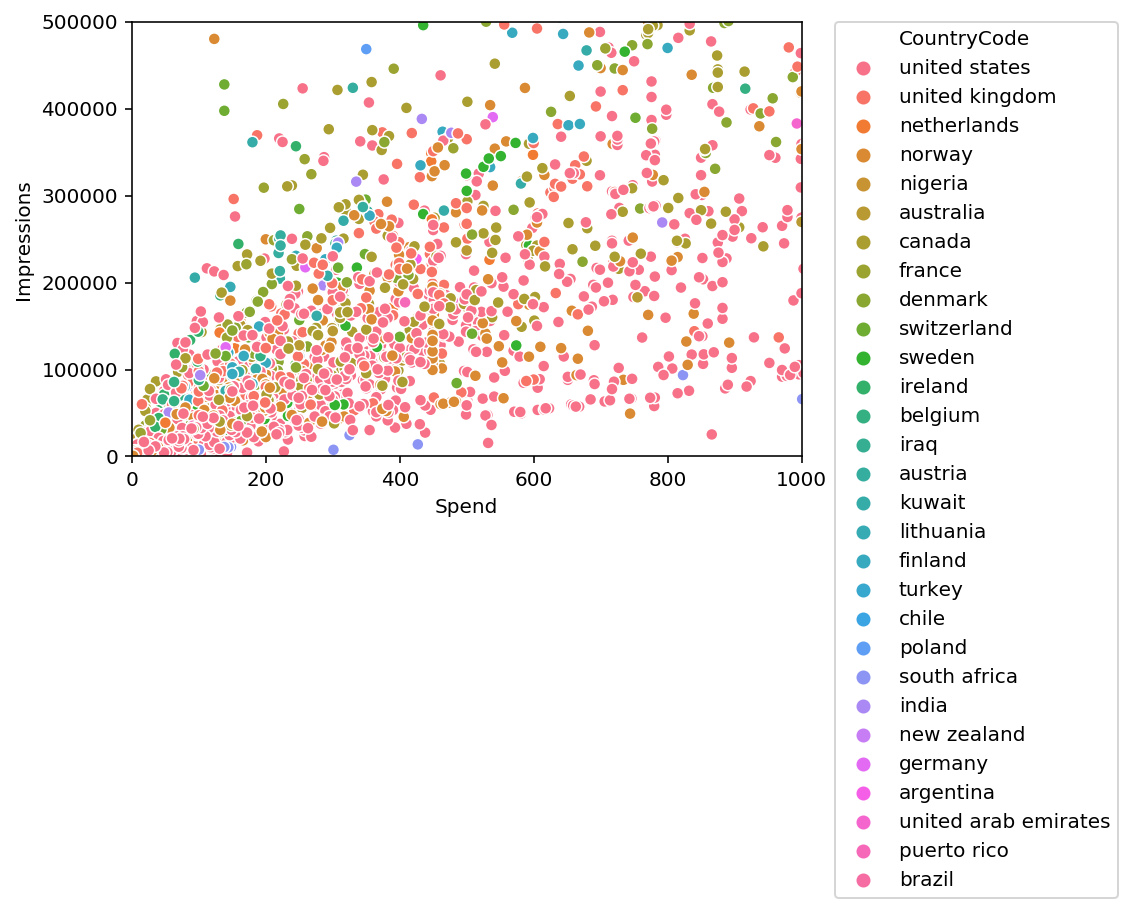

In [4]:
ax = sns.scatterplot(x='Spend', y="Impressions", data=combined_df, hue='CountryCode')

# Set limit on the axes
plt.xlim(0, 1000)
plt.ylim(0, 500000)

# Move legend outside the plot figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

(array([736876., 736938., 736999., 737060., 737119., 737180., 737241.,
        737303., 737364., 737425.]), <a list of 10 Text xticklabel objects>)

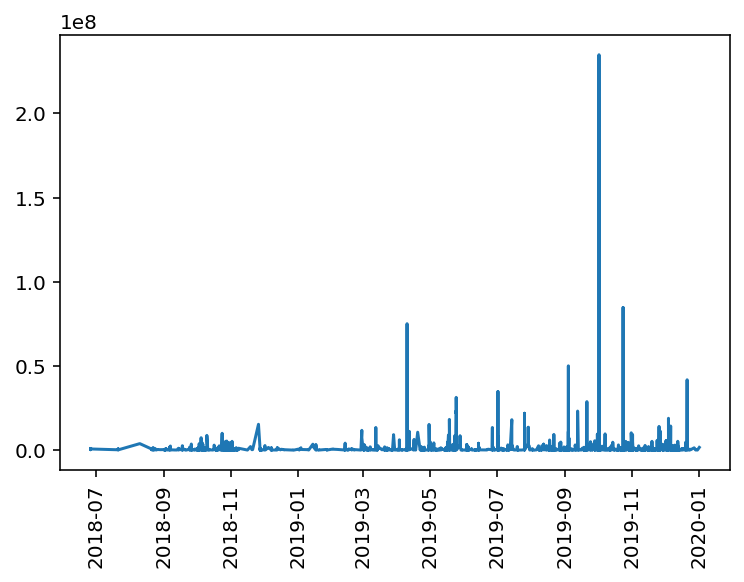

In [5]:
# Plot the StartDate x Impressions
sort_StartDate = combined_df.sort_values('StartDate', ascending=True)
plt.plot(sort_StartDate['StartDate'], sort_StartDate['Impressions'])
plt.xticks(rotation='vertical')

# Baseline Model

In [6]:
# Pick out the baseline features for the model.
model_df = combined_df[['CountryCode','OrganizationName', 'AgeBracket', 'Spend', 'Impressions', 'Segments', 'Interests', 'BillingAddress', 'Currency Code']]
model_df.head()

,CountryCode,OrganizationName,AgeBracket,Spend,Impressions,Segments,Interests,BillingAddress,Currency Code
0,united states,Bully Pulpit Interactive,18-34,623,55373,NaN,NaN,"1445 New York Ave NW,Washington,20005,US",USD
1,united kingdom,The Labour Party,18-24,118,48450,Provided by Advertiser,NaN,"Kings Manor,Newcastle,NE16PA,GB",GBP
2,united states,ACRONYM,18-34,45,13965,Provided by Advertiser,"Collegiates,Green Living Enthusiasts,Outdoor &...",US,USD
3,united states,Bully Pulpit Interactive,18-34,971,91817,NaN,NaN,"1445 New York Ave NW,Washington,20005,US",USD
4,united states,OpenPoll Inc,18-29,102,31835,Provided by Advertiser,NaN,US,USD


In [7]:
# Necessary imports (some were used in the process but not the final report)
from sklearn import linear_model
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [8]:
# Creating the pipeline

# Discerning categorical features
categorical_features = ['CountryCode', 'Currency Code', 'Segments', 'AgeBracket', 'OrganizationName', 'Interests', 'BillingAddress']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = ['Spend']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('stdscaler', StandardScaler())])

base_preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features),
                 ('num', numeric_transformer, numeric_features)])

baseline_pl = Pipeline(steps=[('preprocessor', base_preprocessor),
                      ('regression', linear_model.LinearRegression())])

# Split the train and test portions (random state for reproducibility)
baseX_train, baseX_test, basey_train, basey_test = train_test_split(model_df.drop('Impressions', axis=1), model_df.Impressions, test_size=0.2, random_state=54321)

In [9]:
# predictions based on the model
preds = baseline_pl.fit(baseX_train, basey_train).predict(baseX_test)
preds[:10]

array([ -26066.5484741 ,  -19601.74208802,    4878.89139089,
       4584500.08587878, 1443693.55377732, 2042014.72589255,
       2724390.88004115,  -50403.78513713,  305578.13893557,
        -95605.35020617])

In [10]:
print("baseline r2-score: %f" % r2_score(basey_test.to_list(), list(preds)))

baseline r2-score: 0.252699


# Final Model

In [11]:
# Copied from lab09 and slightly modified
class StdScalerByGroup(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 2, 2], 'c2': [3, 1, 2, 0]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> std.grps_ is not None
        True
        """
        # X may not be a pandas dataframe (e.g. a np.array)
        df = pd.DataFrame(X)
        
        # A dictionary of means/standard-deviations for each column, for each group.
        self.grps_ = {'means': (df.groupby('CountryCode').mean()).to_dict('index'), 'stds': (df.groupby('CountryCode').std()).to_dict('index')}

        return self

    def transform(self, X, y=None):
        """
        :Example:
        >>> cols = {'g': ['A', 'A', 'B', 'B'], 'c1': [1, 2, 3, 4], 'c2': [1, 2, 3, 4]}
        >>> X = pd.DataFrame(cols)
        >>> std = StdScalerByGroup().fit(X)
        >>> out = std.transform(X)
        >>> out.shape == (4, 2)
        True
        >>> np.isclose(out.abs(), 0.707107, atol=0.001).all().all()
        True
        """

        try:
            getattr(self, "grps_")
        except AttributeError:
            raise RuntimeError("You must fit the transformer before tranforming the data!")
        

        # Define a helper function here?
        
        def z_scale(df):

            means = df['CountryCode'].map(self.grps_['means'])
            stds = df['CountryCode'].map(self.grps_['stds'])
            big_df = pd.DataFrame()
                        
            for val in self.grps_['means'].keys():
                new_df = df[df['CountryCode'] == val]
                            
                for col in new_df.drop('CountryCode', axis=1).columns:
                    new_df[col] = (new_df[col] - self.grps_['means'][val][col]) / self.grps_['stds'][val][col]
                                        
                big_df = pd.concat([big_df, new_df])
            
            return big_df
            

        # X may not be a dataframe (e.g. np.array)

        df = pd.DataFrame(X)
                
        return z_scale(df).drop('CountryCode', axis=1)

In [12]:
# Import datetime for the toordinal function
from datetime import datetime

# Import re to transform the AgeBracket column
import re

In [13]:
new_model = model_df.copy()

# Creating the pipeline

# Discerning categorical features
categorical_features = ['Segments', 'AgeBracket', 'OrganizationName', 'Interests', 'BillingAddress']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Turn StartDate into an ordinal variable based on number of days after the very first ad StartDate
new_model['StartDate_ordinal'] = combined_df['StartDate'].apply(datetime.toordinal)
new_model['StartDate_ordinal'] = new_model['StartDate_ordinal'] - new_model['StartDate_ordinal'].min()

# Create a numeric feature of number of ages targeted
new_model['AgesIncluded'] = 64 - new_model.AgeBracket.str.extract('(\d+)').astype(float)
new_model['AgesIncluded'] = new_model['AgesIncluded'].fillna(64)

# Creating a Duration feature
new_model['Duration'] = (combined_df['EndDate'] - combined_df['StartDate']).dt.days
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
new_model['Duration'] = imp_mean.fit_transform(new_model[['Duration']])

# Standard Scale by CountryCode
numeric_scaled = StdScalerByGroup().fit_transform(new_model[['CountryCode', 'Spend', 'AgesIncluded', 'Duration']])
numeric_scaled = numeric_scaled.fillna(0)
numeric_scaled = numeric_scaled.reset_index(drop=True)

# Replaces the original df numeric columns with standard scaled by group
for col in numeric_scaled.columns:
    new_model[col] = numeric_scaled[col]

# Discern numeric features
numerical_features = ['AgesIncluded', 'StartDate_ordinal', 'Duration', 'Spend']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('stdscale', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features),
                 ('num', numerical_transformer, numerical_features)])

pl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', linear_model.LinearRegression())])

# Split the train and test portions (random state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(new_model.drop('Impressions', axis=1), new_model.Impressions, test_size=0.2, random_state=54321)

In [14]:
# predictions based on the model
preds = pl.fit(X_train, y_train).predict(X_test)
preds[:10]

array([  36683.52635112,  184816.23968979,   50381.06012652,
       2498959.55409256,  250884.02271948, 2852963.84839937,
       2994764.01387496, -215061.84368893,  339196.2659536 ,
        132594.48618436])

In [15]:
print("Linear Regression r2-score: %f" % r2_score(y_test.to_list(), list(preds)))

Linear Regression r2-score: 0.458340


## Ridge

In [16]:
# Test multiple alpha values
for alpha in np.arange(0,1.1,0.1):
    # Redefine the pipelines with a Ridge model
    pl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', linear_model.Ridge(alpha=alpha))])

    print('Ridge r2-score for alpha=' + str(round(alpha, 2)) + ':', r2_score(y_test, pl.fit(X_train, y_train).predict(X_test)))

Ridge r2-score for alpha=0.0: 0.4565106650344293
Ridge r2-score for alpha=0.1: 0.4600069294252076
Ridge r2-score for alpha=0.2: 0.4566560256062049
Ridge r2-score for alpha=0.3: 0.4520087159495574
Ridge r2-score for alpha=0.4: 0.4472425375222554
Ridge r2-score for alpha=0.5: 0.44251532176646247
Ridge r2-score for alpha=0.6: 0.4376935481145352
Ridge r2-score for alpha=0.7: 0.4333003386152604
Ridge r2-score for alpha=0.8: 0.4291155056489422
Ridge r2-score for alpha=0.9: 0.425409792481106
Ridge r2-score for alpha=1.0: 0.42210450338698924


In [17]:
# Redefine the pipelines with a Ridge model
# Note: I used alpha=0.1 because it reduces smoothness and allows the coefficients to affect predictions much more.
# However, this is dangerous when accounting for overfitting.
baseline_pl = Pipeline(steps=[('preprocessor', base_preprocessor),
                      ('regression', linear_model.Ridge(alpha=0.1))])

print('baseline Ridge r2-score: ', r2_score(basey_test, baseline_pl.fit(baseX_train, basey_train).predict(baseX_test)))

pl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', linear_model.Ridge(alpha=0.1))])

print('Ridge r2-score: ', r2_score(y_test, pl.fit(X_train, y_train).predict(X_test)))

baseline Ridge r2-score:  0.3904811465876188
Ridge r2-score:  0.4600069294252076


## Lasso

In [18]:
# Test multiple alpha values
for alpha in np.arange(0,1.1,0.1):
    # Redefine the pipelines with a Ridge model
    pl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', linear_model.Lasso(alpha=alpha))])

    print('Lasso r2-score for alpha=' + str(round(alpha, 2)) + ':', r2_score(y_test, pl.fit(X_train, y_train).predict(X_test)))

Lasso r2-score for alpha=0.0: 0.4572633629925241
Lasso r2-score for alpha=0.1: 0.4573476724635088
Lasso r2-score for alpha=0.2: 0.4573571537367912
Lasso r2-score for alpha=0.3: 0.45736264227598467
Lasso r2-score for alpha=0.4: 0.45736525500773806
Lasso r2-score for alpha=0.5: 0.4573698909218087
Lasso r2-score for alpha=0.6: 0.4573773417589797
Lasso r2-score for alpha=0.7: 0.45739405562360136
Lasso r2-score for alpha=0.8: 0.4574045194794477
Lasso r2-score for alpha=0.9: 0.4574209085035438
Lasso r2-score for alpha=1.0: 0.4574402077821965


In [19]:
# Redefine the pipelines with a Lasso model
# Note: I used alpha=0.1 because it reduces smoothness and allows the coefficients to affect predictions much more.
# However, this is dangerous when accounting for overfitting.
baseline_pl = Pipeline(steps=[('preprocessor', base_preprocessor),
                      ('regression', linear_model.Lasso(alpha=1))])

print('baseline r2-score: ', r2_score(basey_test, baseline_pl.fit(baseX_train, basey_train).predict(baseX_test)))

pl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', linear_model.Lasso(alpha=1))])

print('Lasso r2-score: ', r2_score(y_test, pl.fit(X_train, y_train).predict(X_test)))

baseline r2-score:  0.23854346817794436
Lasso r2-score:  0.4574402077821965


## Predicting `Spend`

In [20]:
new_model = model_df.copy()

# Creating the pipeline

# Discerning categorical features
categorical_features = ['Segments', 'AgeBracket', 'OrganizationName', 'Interests', 'BillingAddress']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Turn StartDate into an ordinal variable based on number of days after the very first ad StartDate
new_model['StartDate_ordinal'] = combined_df['StartDate'].apply(datetime.toordinal)
new_model['StartDate_ordinal'] = new_model['StartDate_ordinal'] - new_model['StartDate_ordinal'].min()

# Create a numeric feature of number of ages targeted
new_model['AgesIncluded'] = 64 - new_model.AgeBracket.str.extract('(\d+)').astype(float)
new_model['AgesIncluded'] = new_model['AgesIncluded'].fillna(64)

# Creating a Duration feature
new_model['Duration'] = (combined_df['EndDate'] - combined_df['StartDate']).dt.days
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
new_model['Duration'] = imp_mean.fit_transform(new_model[['Duration']])

# Standard Scale by CountryCode
numeric_scaled = StdScalerByGroup().fit_transform(new_model[['CountryCode', 'Impressions', 'AgesIncluded', 'Duration']])
numeric_scaled = numeric_scaled.fillna(0)
numeric_scaled = numeric_scaled.reset_index(drop=True)

# Replaces the original df numeric columns with standard scaled by group
for col in numeric_scaled.columns:
    new_model[col] = numeric_scaled[col]

# Discern numeric features
numerical_features = ['AgesIncluded', 'StartDate_ordinal', 'Duration']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('stdscale', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features),
                 ('num', numerical_transformer, numerical_features)])

pl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', linear_model.Ridge(alpha=0.1))])

# Split the train and test portions (random state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(new_model.drop('Spend', axis=1), new_model.Spend, test_size=0.2, random_state=54321)

In [21]:
# predictions based on the model
preds = pl.fit(X_train, y_train).predict(X_test)
preds[:10]

array([ 145.4718526 ,  319.26722269,  -96.67274676, 7933.00665251,
       -954.01362301, 3166.44139018, 2311.03811004, -441.53820596,
        614.43315528,  818.2494408 ])

In [22]:
print("Predicting Spend r2-score: %f" % r2_score(y_test.to_list(), list(preds)))

Predicting Spend r2-score: 0.798638


# Fairness Evaluation

In [23]:
# Redefine the Final Model
new_model = model_df.copy()

# Creating the pipeline

# Discerning categorical features
categorical_features = ['Segments', 'AgeBracket', 'OrganizationName', 'Interests', 'BillingAddress']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Turn StartDate into an ordinal variable based on number of days after the very first ad StartDate
new_model['StartDate_ordinal'] = combined_df['StartDate'].apply(datetime.toordinal)
new_model['StartDate_ordinal'] = new_model['StartDate_ordinal'] - new_model['StartDate_ordinal'].min()

# Create a numeric feature of number of ages targeted
new_model['AgesIncluded'] = 64 - new_model.AgeBracket.str.extract('(\d+)').astype(float)
new_model['AgesIncluded'] = new_model['AgesIncluded'].fillna(64)

# Creating a Duration feature
new_model['Duration'] = (combined_df['EndDate'] - combined_df['StartDate']).dt.days
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
new_model['Duration'] = imp_mean.fit_transform(new_model[['Duration']])

# Standard Scale by CountryCode
numeric_scaled = StdScalerByGroup().fit_transform(new_model[['CountryCode', 'Spend', 'AgesIncluded', 'Duration']])
numeric_scaled = numeric_scaled.fillna(0)
numeric_scaled = numeric_scaled.reset_index(drop=True)

# Replaces the original df numeric columns with standard scaled by group
for col in numeric_scaled.columns:
    new_model[col] = numeric_scaled[col]

# Discern numeric features
numerical_features = ['AgesIncluded', 'StartDate_ordinal', 'Duration', 'Spend']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('stdscale', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features),
                 ('num', numerical_transformer, numerical_features)])

pl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regression', linear_model.Ridge(alpha=0.1))])

# Split the train and test portions (random state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(new_model.drop('Impressions', axis=1), new_model.Impressions, test_size=0.2, random_state=54321)

In [24]:
X_test['prediction'] = pl.fit(X_train, y_train).predict(X_test)
X_test['Impressions'] = y_test

In [25]:
# Perform permutation test
obs = X_test.groupby('CountryCode').apply(lambda x: r2_score(x.Impressions, x.prediction)).diff().iloc[-1]

metrs = []
for _ in range(100):
    s = (
        X_test[['CountryCode', 'prediction', 'Impressions']]
        .assign(CountryCode=X_test.CountryCode.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('CountryCode')
        .apply(lambda x: r2_score(x.Impressions, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)
    
print('p_val:', pd.Series(metrs <= obs).mean())

p_val: 0.81
